# Analyze A/B Test Results 

This project will assure you have mastered the subjects covered in the statistics lessons. We have organized the current notebook into the following sections: 

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Final Check](#finalcheck)
- [Submission](#submission)

Specific programming tasks are marked with a **ToDo** tag. 

<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.

Each **ToDo** task below has an associated quiz present in the classroom.  Though the classroom quizzes are **not necessary** to complete the project, they help ensure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the [rubric](https://review.udacity.com/#!/rubrics/1214/view) specification. 


<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

### ToDo 1.1
Now, read in the `ab_data.csv` data. Store it in `df`. Below is the description of the data, there are a total of 5 columns:

<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>
Use your dataframe to answer the questions in Quiz 1 of the classroom.


>**Tip**: Please save your work regularly.

**a.** Read in the dataset from the `ab_data.csv` file and take a look at the top few rows here:

In [2]:
#Read in ab dataframe.
df_ab = pd.read_csv('ab_data.csv')


In [3]:
#show head of df.
df_ab.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**b.** Use the cell below to find the number of rows in the dataset.

In [4]:
#rows / columns of ab test data and rows
df_ab.shape

(294478, 5)

**c.** The number of unique users in the dataset.

In [5]:
#number of unique users in ab test dataset.
df_ab.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

**d.** The proportion of users converted.

In [6]:
#calculate converted vs not converted
converted = (df_ab['converted'] == 1).sum()
not_converted = (df_ab['converted'] == 0).sum()
total = converted + not_converted
#The proportion of users converted.
(converted/total)

0.11965919355605512

**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [7]:
#The dataframe below contains all of the entries that the new 'treatment' group were not sent to the new page and those entries for the 'control' but not sent to the old page.
filtered_treat_df =  df_ab.query('group != "treatment" & landing_page =="new_page"')
filtered_control_df =  df_ab.query('group != "control" & landing_page =="old_page"')

In [8]:
#the calculation below is the total of both groups which were incorrectly assigned.
total = filtered_treat_df.count() + filtered_control_df.count()
total

user_id         3893
timestamp       3893
group           3893
landing_page    3893
converted       3893
dtype: int64

**f.** Do any of the rows have missing values?

In [9]:
#Search for null / missing values
df_ab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [10]:
#4 groups (treatment / control, new page / old page)
treat_old =  df_ab.query('group == "treatment" & landing_page =="old_page"')
treat_new =  df_ab.query('group == "treatment" & landing_page =="new_page"')
control_old =  df_ab.query('group == "control" & landing_page =="old_page"')
control_new =  df_ab.query('group == "control" & landing_page =="new_page"')
#df_ab.count(),
treat_old.count(),  treat_new.count(), control_old.count(), control_new.count()
#This means we should remove the treatment / old (1965 entries) and the control / new (1928 entries), total 3893 entries

(user_id         1965
 timestamp       1965
 group           1965
 landing_page    1965
 converted       1965
 dtype: int64, user_id         145311
 timestamp       145311
 group           145311
 landing_page    145311
 converted       145311
 dtype: int64, user_id         145274
 timestamp       145274
 group           145274
 landing_page    145274
 converted       145274
 dtype: int64, user_id         1928
 timestamp       1928
 group           1928
 landing_page    1928
 converted       1928
 dtype: int64)

### ToDo 1.2  
In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  


Use **Quiz 2** in the classroom to figure out how should we handle the rows where the group and landing_page columns don't match?

**a.** Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [11]:
#All of the treatment and old_page entries indexed, for removal.
treat_old_index = treat_old.index
#treat_old_index

In [12]:
#All of the control and new_page entries indexed, for removal.
control_new_index = control_new.index
#control_new_index

In [13]:
# Remove the inaccurate rows (treatment and old page, also control and new page), and store the result in a new dataframe df2

df2 =  df_ab.drop(index = treat_old_index)
df2 =  df2.drop(index = control_new_index)

df2.count()

user_id         290585
timestamp       290585
group           290585
landing_page    290585
converted       290585
dtype: int64

In [14]:
#test to prove that both inaccurate sets of data have been removed.
treat_old_df2 =  df2.query('group == "treatment" & landing_page =="old_page"')
control_new_df2 =  df2.query('group == "control" & landing_page =="new_page"')
treat_old_df2.count(), control_new_df2.count()

(user_id         0
 timestamp       0
 group           0
 landing_page    0
 converted       0
 dtype: int64, user_id         0
 timestamp       0
 group           0
 landing_page    0
 converted       0
 dtype: int64)

In [15]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

### ToDo 1.3  
Use **df2** and the cells below to answer questions for **Quiz 3** in the classroom.

**a.** How many unique **user_id**s are in **df2**?

In [16]:
#number of unique users in df2 dataset.
df2['user_id'].nunique()

290584

**b.** There is one **user_id** repeated in **df2**.  What is it?

In [17]:
#number of unique users in df2 dataset.
sum(df2['user_id'].duplicated())

1

**c.** Display the rows for the duplicate **user_id**? 

In [18]:
#row information of the duplicated user_id
duplicated_user = df2.query('user_id == "773192"')
duplicated_user

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [19]:
# Remove one of the rows with a duplicate user_id..
# Hint: The dataframe.drop_duplicates() may not work in this case because the rows with duplicate user_id are not entirely identical. 
df2 = df2.drop_duplicates()
# Check again if the row with a duplicate user_id is deleted or not
check_duplicate = df2.query('user_id == "773192"')
check_duplicate

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [20]:
#row information of the duplicated user_id
duplicated_user = df2.query('user_id == "773192"')
duplicated_user

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


### ToDo 1.4  
Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

**a.** What is the probability of an individual converting regardless of the page they receive?<br><br>




In [21]:
df2_rows = len(df2)
df2_rows

290585

In [22]:
#The probability of an individual converting from the both groups combined.
converted = df2['converted'].sum()
converted/df2_rows

0.11959667567149027

**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [23]:
#The probability of an individual converting from the control group.
control = df2.query('group == "control"')
control_len = len(control)
control_converted =  df2.query('group == "control" & converted =="1"')
control_converted_len = len(control_converted)
control_convert_prob = control_converted_len/control_len
control_convert_prob

0.1203863045004612

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [24]:
#The probability of an individual converting from the treatment group.
treatment = df2.query('group == "treatment"')
treatment_len = len(treatment)
treatment_converted =  df2.query('group == "treatment" & converted =="1"')
treatment_converted_len = len(treatment_converted)
treat_convert_prob = treatment_converted_len/treatment_len
treat_convert_prob

0.11880724790277405

In [25]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = treat_convert_prob - control_convert_prob
obs_diff

-0.0015790565976871451

**d.** What is the probability that an individual received the new page?

In [26]:
treatment_len/df2_rows

0.5000636646764286

**e.** Consider your results from parts (a) through (d) above, and explain below whether the new `treatment` group users lead to more conversions.

For this experiment, there were a total of ~290k observations, which were split between a control and an experiment groups.  Specifically, this tested the convertion rate between 2 landing pages; the old page verses the new page. 
The probability of receiveing each page was broadly equal.  
The conversion rate for the control (old page), was 12%, whereas the conversion rate for the treatment (new page), was 11.8%.
Across both the control and the treatment groups, the conversion rate was 11.9%.
To conclude, the conversion rate for the new page was very slightly worse that the old page.

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, you could run a hypothesis test continuously as long as you observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


### ToDo 2.1
For now, consider you need to make the decision just based on all the data provided.  

> Recall that you just calculated that the "converted" probability (or rate) for the old page is *slightly* higher than that of the new page (ToDo 1.4.c). 

If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should be your null and alternative hypotheses (**$H_0$** and **$H_1$**)?  

You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the "converted" probability (or rate) for the old and new pages respectively.

1. Directional Hypothesis, aims to prove the alternateive is better than the null.
> **$H_0$**: $p_{new}$ $\leq$ **$p_{old}$**<br>
> **$H_1$**: $p_{new}$ > **$p_{old}$** <br>

2. Non-directional hypothesis, just aims to prove the alternative is different from the null.
> **$H_0$**: $p_{old}$ - **$p_{new}$** = 0<br>
> **$H_1$**: $p_{old}$ - **$p_{new}$** $\neq$ 0 <br>

3. Hypotheses which takes into account the Type 1 error rate
>**$p_{val}$** $\leq$ α => Reject **$H_0$** <br>
>**$p_{val}$** > α => Fail to Reject **$H_0$** <br>

### ToDo 2.2 - Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, you will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 



Use the cells below to provide the necessary parts of this simulation.  You can use **Quiz 5** in the classroom to make sure you are on the right track.

**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [27]:
df2_sample_data = df2.sample(200)
df2_sample_data.head(1)

,user_id,timestamp,group,landing_page,converted
157001,791617,2017-01-05 04:23:21.715531,treatment,new_page,0


In [29]:
#variables defined for n_new (total amount in treatment group), n_old (total amount in control group)
n_new = len(treatment)
n_old = len(control)


In [31]:
#variables defined for p_new & p_old, which takes the previously defined variables which have captured the probability of both groups converting.
p_new = np.array(treat_convert_prob).mean()
p_old = np.array(control_convert_prob).mean()

In [32]:
# The code below processes the mean of p_new and p_old (10000 times), then calculates the difference.
p_new_means = np.random.binomial(n_new, p_new, 10000)/n_new
p_old_means = np.random.binomial(n_old, p_old, 10000)/n_old
diffs = p_new_means - p_old_means

In [ ]:
#please ignore this block of code.
#the 3 seperate datasets for the loop to append data to.
#p_new_means, p_old_means, diffs = [], [], []

#the loop to sample the data, seperate the converted control, from converted treatment
#for _ in range(10000):
    #bootsamp = df2_sample_data.sample(df2.shape[0], replace = True)
    #p_old_mean = bootsamp[bootsamp['group'] == "control"]['converted'].mean()
    #p_new_mean = bootsamp[bootsamp['group'] == "treatment"]['converted'].mean() 
     
#append the info
    #p_old_means.append(p_old_mean)
    #p_new_means.append(p_new_mean)
    #diffs.append(p_new_mean - p_old_mean)

In [33]:
#the standard deviation of the sampling distribution for the new page.
np.std(p_new_means)

0.00085881559253375272

In [34]:
#the standard deviation of the sampling distribution for the old page.
np.std(p_old_means)

0.00086050016484943634

In [35]:
#the standard deviation of the sampling distribution for the difference in means.
np.std(diffs)

0.0012188482409457241

(array([   15.,   146.,   739.,  2021.,  2949.,  2595.,  1152.,   332.,
           46.,     5.]),
 array([ 0.11721987,  0.1178924 ,  0.11856492,  0.11923744,  0.11990996,
         0.12058249,  0.12125501,  0.12192753,  0.12260005,  0.12327257,
         0.1239451 ]),
 <a list of 10 Patch objects>)

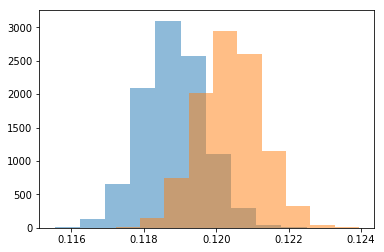

In [36]:
#create histograms for both p_new and p_old
plt.hist(p_new_means, alpha = 0.5)
plt.hist(p_old_means, alpha = 0.5)

(array([   28.,   156.,   726.,  1731.,  2671.,  2531.,  1478.,   541.,
          121.,    17.]),
 array([-0.00581854, -0.00495136, -0.00408418, -0.003217  , -0.00234982,
        -0.00148264, -0.00061546,  0.00025172,  0.0011189 ,  0.00198608,
         0.00285326]),
 <a list of 10 Patch objects>)

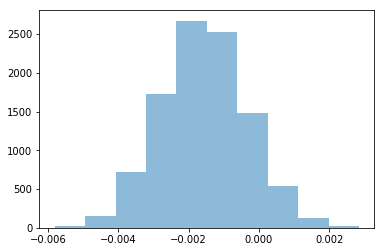

In [37]:
#create histograms for both diffs
plt.hist(diffs, alpha = 0.5)

In [38]:
#simulate null valls x 10k.
null_vals = np.random.normal(0, np.std(diffs), 10000)

(array([   15.,   136.,   695.,  2023.,  2961.,  2583.,  1239.,   303.,
           41.,     4.]),
 array([-0.00449959, -0.0035505 , -0.00260141, -0.00165232, -0.00070323,
         0.00024586,  0.00119495,  0.00214404,  0.00309314,  0.00404223,
         0.00499132]),
 <a list of 10 Patch objects>)

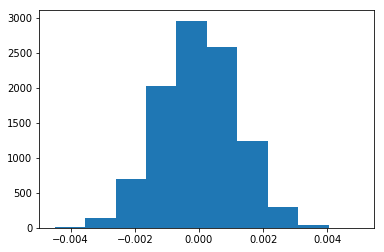

In [39]:
#create histograms for null vals
plt.hist(null_vals)

In [40]:
#p_new_null and p_old_null are assumed to be the same
p_old_null = df2.converted.mean()
p_new_null = df2.converted.mean()
p_old_null, p_new_null

(0.11959667567149027, 0.11959667567149027)

In [41]:
#print the top rows of the df2 dataset.
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [42]:
#the conversion rate of the old page under the null hypthoesis 
#the formula for conversion rate is: # of clicks by unique users / # views by unique users

old_conversion_rate = df2.query('group == "control"').user_id.nunique() / len(df2)
old_conversion_rate


0.4999363353235714

**c.** What is $n_{new}$, the number of individuals in the treatment group? <br><br>
*Hint*: The treatment group users are shown the new page.

In [43]:
# number of members in the treatment group.
n_new = len(treatment)
n_new

145311

**d.** What is $n_{old}$, the number of individuals in the control group?

In [44]:
# number of members in the control group.
n_old = len(control)
n_old

145274

**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>
*Hint*: Use `numpy.random.choice()` method to randomly generate $n_{new}$ number of values. <br>
Store these $n_{new}$ 1's and 0's in the `new_page_converted` numpy array.


In [45]:
# Simulate a Sample for the treatment Group
new_page_converted = np.random.choice([0,1],size=n_new, p=[1-p_new,p_new])
new_page_converted

array([0, 0, 0, ..., 0, 0, 0])

**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [46]:
# Simulate a Sample for the control Group
old_page_converted = np.random.choice([0,1],size=n_new, p=[1-p_old,p_old])
old_page_converted

array([0, 0, 0, ..., 0, 0, 0])

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [47]:
#difference in converted probability
(new_page_converted.sum() - old_page_converted.sum())

-294


**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used in parts (a) through (g) above. 

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [48]:
# Sampling distribution 

#Bootstrap the results 10000 times for both the control and treatment groups.
p_diffs = []
for _ in range(1000):
    b_samp = df2.sample(df2.shape[0], replace = True)
    old_page_converted = b_samp.query('group == "control" & converted =="1"')
    old_page_converted = old_page_converted['user_id'].nunique()
    old_page_conversion_rate = old_page_converted / df2_rows
    new_page_converted = b_samp.query('group == "treatment" & converted =="1"')
    new_page_converted = new_page_converted['user_id'].nunique()
    new_page_conversion_rate = new_page_converted / df2_rows
    p_diffs.append(new_page_conversion_rate - old_page_conversion_rate)


**i. Histogram**<br> 
Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.<br><br>

Also, use `plt.axvline()` method to mark the actual difference observed  in the `df2` data (recall `obs_diff`), in the chart.  

>**Tip**: Display title, x-label, and y-label in the chart.

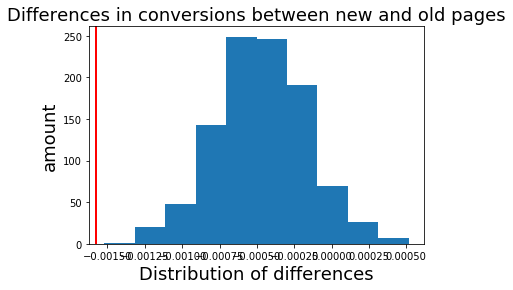

In [49]:
#histogram of p_diffs (which is the difference between the new_page and the old_page)
plt.hist(p_diffs);
plt.title('Differences in conversions between new and old pages', fontsize = 18)
plt.xlabel('Distribution of differences', fontsize = 18)
plt.ylabel('amount', fontsize = 18)
#axvline of the obs_diff
plt.axvline(obs_diff, color='r', linewidth=2)

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [50]:
#The observed difference between the treatment and control groups.
obs_diff = df2.query('group == "treatment"').converted.mean() - df2.query('group == "control"').converted.mean()

**k.** Please explain in words what you have just computed in part **j** above.  
 - What is this value called in scientific studies?  
 - What does this value signify in terms of whether or not there is a difference between the new and old pages? *Hint*: Compare the value above with the "Type I error rate (0.05)". 

**Answer**<br>
We created a sample group for the control (using the old page) and a sample for the treatment (using the new page), then bootstraped both samples 10k times, with the difference between these groups ploted on a histogram.   A line was applied to this histogram, showing the obs_diff (which is the convertion probability of the treatment - the convertion probability of the control).

The proportion between the bootstraped sample (p_diffs) and the observed difference (obs_diff) is 0.83 or 83%.



**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

Fill in the statements below to calculate the:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [51]:
import statsmodels.api as sm

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [52]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [53]:
# number of conversions with the old_page
convert_old = df2.query('group == "control" & converted =="1"').sum()

# number of conversions with the new_page
convert_new = df2.query('group == "treatment" & converted =="1"').sum()

# number of individuals who were shown the old_page
n_old = len(control)

# number of individuals who received new_page
n_new = len(treatment)

convert_old, convert_new, n_old, n_new

(user_id                                               13770361866
 timestamp       2017-01-21 01:52:26.2108272017-01-22 02:05:21....
 group           controlcontrolcontrolcontrolcontrolcontrolcont...
 landing_page    old_pageold_pageold_pageold_pageold_pageold_pa...
 converted                                                   17489
 dtype: object,
 user_id                                               13630386061
 timestamp       2017-01-19 03:26:46.9407492017-01-04 17:58:08....
 group           treatmenttreatmenttreatmenttreatmenttreatmentt...
 landing_page    new_pagenew_pagenew_pagenew_pagenew_pagenew_pa...
 converted                                                   17264
 dtype: object,
 145274,
 145311)

**m.** Now use `sm.stats.proportions_ztest()` to compute your test statistic and p-value.  [Here](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html) is a helpful link on using the built in.

The syntax is: 
```bash
proportions_ztest(count_array, nobs_array, alternative='larger')
```
where, 
- `count_array` = represents the number of "converted" for each group
- `nobs_array` = represents the total number of observations (rows) in each group
- `alternative` = choose one of the values from `[‘two-sided’, ‘smaller’, ‘larger’]` depending upon two-tailed, left-tailed, or right-tailed respectively. 
>**Hint**: <br>
It's a two-tailed if you defined $H_1$ as $(p_{new} = p_{old})$. <br>
It's a left-tailed if you defined $H_1$ as $(p_{new} < p_{old})$. <br>
It's a right-tailed if you defined $H_1$ as $(p_{new} > p_{old})$. 

The built-in function above will return the z_score, p_value. 

---
### About the two-sample z-test
Recall that you have plotted a distribution `p_diffs` representing the
difference in the "converted" probability  $(p{'}_{new}-p{'}_{old})$  for your two simulated samples 10,000 times. 

Another way for comparing the mean of two independent and normal distribution is a **two-sample z-test**. You can perform the Z-test to calculate the Z_score, as shown in the equation below:

$$
Z_{score} = \frac{ (p{'}_{new}-p{'}_{old}) - (p_{new}  -  p_{old})}{ \sqrt{ \frac{\sigma^{2}_{new} }{n_{new}} + \frac{\sigma^{2}_{old} }{n_{old}}  } }
$$

where,
- $p{'}$ is the "converted" success rate in the sample
- $p_{new}$ and $p_{old}$ are the "converted" success rate for the two groups in the population. 
- $\sigma_{new}$ and $\sigma_{new}$ are the standard deviation for the two groups in the population. 
- $n_{new}$ and $n_{old}$ represent the size of the two groups or samples (it's same in our case)


>Z-test is performed when the sample size is large, and the population variance is known. The z-score represents the distance between the two "converted" success rates in terms of the standard error. 

Next step is to make a decision to reject or fail to reject the null hypothesis based on comparing these two values: 
- $Z_{score}$
- $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval.  $Z_{0.05}$ is 1.645 for one-tailed tests,  and 1.960 for two-tailed test. You can determine the $Z_{\alpha}$ from the z-table manually. 

Decide if your hypothesis is either a two-tailed, left-tailed, or right-tailed test. Accordingly, reject OR fail to reject the  null based on the comparison between $Z_{score}$ and $Z_{\alpha}$. We determine whether or not the $Z_{score}$ lies in the "rejection region" in the distribution. In other words, a "rejection region" is an interval where the null hypothesis is rejected iff the $Z_{score}$ lies in that region.

>Hint:<br>
For a right-tailed test, reject null if $Z_{score}$ > $Z_{\alpha}$. <br>
For a left-tailed test, reject null if $Z_{score}$ < $Z_{\alpha}$. 




Reference: 
- Example 9.1.2 on this [page](https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Book%3A_Introductory_Statistics_(Shafer_and_Zhang)/09%3A_Two-Sample_Problems/9.01%3A_Comparison_of_Two_Population_Means-_Large_Independent_Samples), courtesy www.stats.libretexts.org

---

>**Tip**: You don't have to dive deeper into z-test for this exercise. **Try having an overview of what does z-score signify in general.** 

In [54]:
import statsmodels.api as sm
# ToDo: Complete the sm.stats.proportions_ztest() method arguments
count_array = np.array([17489, 17264])
nobs_array = np.array([145274, 145311])
z_score, p_value = sm.stats.proportions_ztest(count_array, nobs_array, alternative='larger')
print(z_score, p_value)

1.31160753391 0.0948262948594


**n.** What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?<br><br>

>**Tip**: Notice whether the p-value is similar to the one computed earlier. Accordingly, can you reject/fail to reject the null hypothesis? It is important to correctly interpret the test statistic and p-value.

>**Answer**<br>
The Z-Score result of 1.3 tell us that the result is 1.3 deviations away from the mean.
The P_value result of 0.094 (or 9.4%) tells us that the result has a 9.4% chance that the null hypothesis is correct.

<a id='regression'></a>
### Part III - A regression approach

### ToDo 3.1 
In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**a.** Since each row in the `df2` data is either a conversion or no conversion, what type of regression should you be performing in this case?

>**Logistic Regression should be used in this case, due to the variables being binary.**

**b.** The goal is to use **statsmodels** library to fit the regression model you specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, you first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [55]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [56]:
group_dummies = pd.get_dummies(df2['group'])
df2_new = df2.join(group_dummies)
df2_new.head()

,user_id,timestamp,group,landing_page,converted,control,treatment
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


In [58]:
df2_new = df2_new.rename(columns={"treatment": "ab_page"})
df2_new.head()

,user_id,timestamp,group,landing_page,converted,control,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


In [ ]:
#df2_new['intercept'] = pd.Series(["1" for x in range(len(df2_new.index))])
#df2_new.head()

**c.** Use **statsmodels** to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [62]:
df2_new['intercept'] = 1

logit_mod = sm.Logit(df2_new['converted'], df2_new[['intercept', 'ab_page']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**d.** Provide the summary of your model below, and use it as necessary to answer the following questions.

In [63]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-04-23 07:05 AIC:              212780.6032
No. Observations:   290585           BIC:              212801.7625
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290583           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3116  0.1897  -0.0374   0.0074
==================================================================

"""

**e.** What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  

**Hints**: 
- What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**? 
- You may comment on if these hypothesis (Part II vs. Part III) are one-sided or two-sided. 
- You may also compare the current p-value with the Type I error rate (0.05).


>**Answer**
The P-Value associated with the ab page is 0.60 or 60%.
The hypothesis in part 2, was a one tailed test, whereas this is a 2 tailed test.
A larger P_value means that there is a smaller probability of a type 1 error occuring.


**f.** Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

>**In this case, there is no value in adding any additional criteria into the model.  Essentially, the new vs old column and the treatment vs control columnn refer to the same information.**

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1. You will need to read in the **countries.csv** dataset and merge together your `df2` datasets on the appropriate rows. You call the resulting dataframe `df_merged`. [Here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) are the docs for joining tables. 

2. Does it appear that country had an impact on conversion?  To answer this question, consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns. 
>**Hint:** Use `pandas.get_dummies()` to create dummy variables. **You will utilize two columns for the three dummy variables.** 

 Provide the statistical output as well as a written response to answer this question.

In [80]:
# Read the countries.csv
df_countries = pd.read_csv('countries.csv')

In [81]:
df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [93]:
df2_new.head()

,user_id,timestamp,group,landing_page,converted,control,ab_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1


In [94]:
# Join with the df2 dataframe

df2_merge = df2_new.merge(df_countries, on = 'user_id', how = 'left')
df2_merge.head()

,user_id,timestamp,group,landing_page,converted,control,ab_page,intercept,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,US


In [ ]:
#df2_merge['UK_ab_page'] = df2_merge['country == "UK"'] * df2_merge['ab_page']

In [95]:
# Create the necessary dummy variables
country_dummies = pd.get_dummies(df2_merge['country'])


In [96]:
country_dummies.head(1)

,CA,UK,US
0,0,0,1


In [97]:
df2_merge = df2_merge.join(country_dummies)
df2_merge.head(1)

,user_id,timestamp,group,landing_page,converted,control,ab_page,intercept,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,US,0,0,1


**h. Fit your model and obtain the results**<br> 
Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.  **Create the necessary additional columns, and fit the new model.** 


Provide the summary results (statistical output), and your conclusions (written response) based on the results. 

>**Tip**: Conclusions should include both statistical reasoning, and practical reasoning for the situation. 

>**Hints**: 
- Look at all of p-values in the summary, and compare against the Type I error rate (0.05). 
- Can you reject/fail to reject the null hypotheses (regression model)?
- Comment on the effect of page and country to predict the conversion.


In [98]:
# Create the necessary dummy variables for each page.
page_dummies = pd.get_dummies(df2_merge['landing_page'])
page_dummies.head(1)

,new_page,old_page
0,0,1


In [99]:
df2_merge = df2_merge.join(page_dummies)
df2_merge.head(1)

,user_id,timestamp,group,landing_page,converted,control,ab_page,intercept,country,CA,UK,US,new_page,old_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,US,0,0,1,0,1


In [130]:
#create an interaction of the UK column and the ab page to create a UK AB page column.
ukab =  df2_merge['UK'] * df2_merge['ab_page']
ukab['UK_ab_page']
ukab.head(1)

KeyError: 'UK_ab_page'

In [121]:
#create an interaction of the US column and the ab page to create a US AB page column.
usab['UK_ab_page'] =  df2_merge['US'] * df2_merge['ab_page']
usab.head()

0    0
1    0
2    1
3    1
4    0
dtype: object

In [125]:
df2_merge = df2_merge.join(ukab)
df2_merge.head(1)

ValueError: Other Series must have a name

In [75]:
# Model fitted with summarised results for the new page.
df2_merge['intercept'] = 1

lm = sm.OLS(df2_merge['new_page'], df2_merge[['intercept', 'CA', 'UK']])
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               new_page   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8954
Date:                Sat, 23 Apr 2022   Prob (F-statistic):              0.408
Time:                        07:08:42   Log-Likelihood:            -2.1090e+05
No. Observations:              290585   AIC:                         4.218e+05
Df Residuals:                  290582   BIC:                         4.218e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.5005      0.001    451.658      0.000       0.498       0.503
CA             0.0031      0.004      0.719      0.472      -0.005       0.012
UK            -0.0022      0.002     -1.024      0.306      -0.006       0.002
==============================================================================
Omnibus:                   989756.053   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            48429.639
Skew:                          -0.000   Prob(JB):                         0.00
Kurtosis:                       1.000   Cond. No.                         4.84
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [76]:
# Model fitted with summarised results for the old page.
df2_merge['intercept'] = 1

lm = sm.OLS(df2_merge['old_page'], df2_merge[['intercept', 'CA', 'UK']])
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               old_page   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8954
Date:                Sat, 23 Apr 2022   Prob (F-statistic):              0.408
Time:                        07:08:45   Log-Likelihood:            -2.1090e+05
No. Observations:              290585   AIC:                         4.218e+05
Df Residuals:                  290582   BIC:                         4.218e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4995      0.001    450.825      0.000       0.497       0.502
CA            -0.0031      0.004     -0.719      0.472      -0.012       0.005
UK             0.0022      0.002      1.024      0.306      -0.002       0.006
==============================================================================
Omnibus:                   989756.053   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            48429.639
Skew:                           0.000   Prob(JB):                         0.00
Kurtosis:                       1.000   Cond. No.                         4.84
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

>**Answer: The results of linear regression, suggests that the probability of landing on new and old pages is the same, however there are differences between countries (with a P-Value of .47 for CA and .30 for the UK).**

<a id='finalcheck'></a>
## Final Check!

Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!

> **Tip**: Once you are satisfied with your work here, check over your notebook to make sure that it satisfies all the specifications mentioned in the rubric. You should also probably remove all of the "Hints" and "Tips" like this one so that the presentation is as polished as possible.


<a id='submission'></a>
## Submission
You may either submit your notebook through the "SUBMIT PROJECT" button at the bottom of this workspace, or you may work from your local machine and submit on  the last page of this project lesson.  

1. Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).


2. Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.


3. Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])